# MO436A Project1: Reinforced learning algorithms evaluation

# 1. Problem description 

**Motivation** 

Model an agent to operate in a trading environment. 

**Objectve** 

The agent objective is to maximize the gain. 


# 2. Environments 

## 2.1 Stocrastic

The trading problem is pretty stocrastic, so, to simplify the model, the prices are simulated with simplified version of the Geometric Brownian motion.

This is an example of pricing data generated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mean_return = -0.01  # average hourly return (negative = downward trend)
volatility = 0.03     # standard deviation of returns (3% volatility)

def generate_intraday_prices(num_days=100, hours_per_day=10, start_price=10):
    prices = []
    for _ in range(num_days):
        dt = 1 / hours_per_day 
        drift = (mean_return - 0.5 * volatility**2) * dt
        shock = np.random.normal(loc=0, scale=volatility * np.sqrt(dt), size=hours_per_day)
        #returns = np.random.normal(loc=mean_return, scale=volatility, size=hours_per_day)
        returns = drift + shock
        day_prices = start_price * np.exp(np.cumsum(returns))
        prices.append(day_prices)
    plot_prices(np.array(prices), num_days)
    return np.array(prices)


def plot_prices(prices, num_days):
    # ----- Cálculo da variação diária -----
    # Variação absoluta (fechamento - abertura) e percentual
    open_prices = prices[:, 0]
    close_prices = prices[:, -1]
    daily_abs_change = close_prices - open_prices
    daily_pct_change = (close_prices / open_prices - 1) * 100

    # ----- Figura: Variação do preço por dia (percentual) -----
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar(np.arange(1, num_days+1), daily_pct_change, color=['#2ca02c' if x>=0 else '#d62728' for x in daily_pct_change], width=0.8)

    ax.set_title('Variação percentual diária do preço (fechamento vs. abertura)')
    ax.set_xlabel('Dia')
    ax.set_ylabel('Variação (%)')

    # Linha na horizontal em 0%
    ax.axhline(0, color='black', linewidth=1)

    # Melhores rótulos no eixo x (marcar a cada 5 dias)
    ax.set_xticks(np.arange(1, num_days+1, 5))

    # Texto com estatísticas básicas
    mean_change = np.mean(daily_pct_change)
    std_change = np.std(daily_pct_change)
    ax.text(0.99, 0.02, f'Média: {mean_change:.2f}%\nDesvio-padrão: {std_change:.2f}%', transform=ax.transAxes,
            ha='right', va='bottom', bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

    plt.tight_layout()
    output_file = 'variacao_diaria_percentual.png'
    plt.savefig(output_file, dpi=220)

    # Também salvar a série de variação absoluta (opcional, segunda figura)
    fig2, ax2 = plt.subplots(figsize=(3, 3))
    ax2.plot(np.arange(1, num_days+1), daily_abs_change, marker='o', linewidth=1.5, color='#1f77b4')
    ax2.set_title('Variação absoluta diária do preço (fechamento - abertura)')
    ax2.set_xlabel('Dia')
    ax2.set_ylabel('Δ Preço')
    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_xticks(np.arange(1, num_days+1, 5))
    plt.tight_layout()
    output_file2 = 'variacao_diaria_absoluta.png'
    plt.savefig(output_file2, dpi=220)


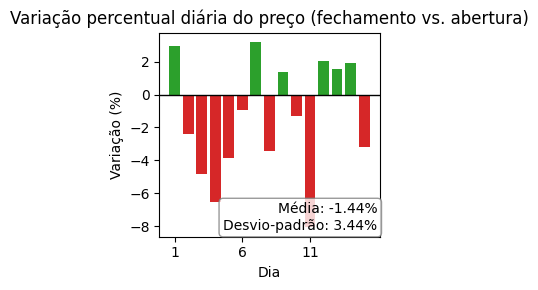

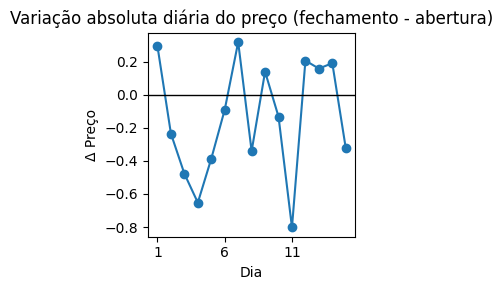

In [2]:
prices = generate_intraday_prices(num_days=15, hours_per_day=10, start_price=10)

With this simulated price, it is possible to define the environment. The gymnasium framework was used to build the ambient.

In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, data, window_size=3):
        super(TradingEnv, self).__init__()
        self.data = data  # dados no formato (dias, horas)
        self.num_days, self.hours_per_day = data.shape
        self.window_size = window_size
        self.current_day = 0
        self.current_step = window_size
        self.initial_cash = 100
        self.cash = self.initial_cash
        self.shares = 0
        self.position = 0
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size + 1,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        self.current_day = np.random.randint(0, self.num_days)  # escolhe um dia aleatório
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.shares = 0
        self.position = 0
        return self._get_obs(), {}

    def step(self, action):
        price = self.data[self.current_day, self.current_step]
        if action == 1 and self.position <= 0:  # comprar
            self.shares = self.cash / price
            self.cash = 0
            self.position = 1
        elif action == 2 and self.position >= 0:  # vender
            self.cash = self.shares * price
            self.shares = 0
            self.position = -1

        portfolio_value = self.cash + self.shares * price
        reward = portfolio_value - self.initial_cash
        obs = self._get_obs()
        self.current_step += 1
        done = self.current_step >= self.hours_per_day  # fim do dia
        return obs, reward, done, False, {}

    def _get_obs(self):
        window = self.data[self.current_day, self.current_step - self.window_size:self.current_step]
        return np.append(window, self.position).astype(np.float32)
    def render(self, mode="human"):
        step_index = min(self.current_step - 1, self.hours_per_day - 1)
        price = self.data[self.current_day, step_index]
        portfolio_value = self.cash + self.shares * price 
        print(f"Step {self.current_step}: Price={price:.2f}, Cash={self.cash:.2f}, Shares={self.shares:.4f}, Portfolio={portfolio_value:.2f}")

In [4]:
env = TradingEnv(prices)
state, _ = env.reset()
env.current_step = 0
env.render()
for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    if done:
        break
    env.render()

Step 0: Price=9.12, Cash=100.00, Shares=0.0000, Portfolio=100.00
Step 1: Price=9.92, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 2: Price=9.89, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 3: Price=9.65, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 4: Price=9.68, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 5: Price=9.58, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 6: Price=9.54, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 7: Price=9.44, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 8: Price=9.34, Cash=0.00, Shares=0.0000, Portfolio=0.00
Step 9: Price=9.17, Cash=0.00, Shares=0.0000, Portfolio=0.00


The following code shows the environement initialization and the result of taking 10 random steps

## 2.2 Deterministic environment

In this case, the deterministic events means the system might know, given the current price of the stock, what will be the price of the stock in the next hour (next step). The The Rulkov Map is used to generate price movements deterministically, since it can create a "caotic" price evolution, mantaining. 


In [5]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class DeterministicTradingEnv(gym.Env):
    """
    Deterministic trading environment using the Rulkov Map for price generation.
    
    The Rulkov Map is a chaotic dynamical system that generates deterministic,
    reproducible price movements without randomness.
    """
    
    metadata = {"render_modes": ["human"]}

    def __init__(self, n_steps=10, start_price=10.0,
                 alpha=4.0, beta=10.0, sigma=0.01, mu=0.001,
                 window_size=3):
        """
        Initialize the deterministic trading environment.
        
        Args:
            n_steps: Number of steps per episode (trading hours)
            start_price: Initial asset price
            alpha, beta, sigma, mu: Rulkov Map parameters
            window_size: Number of historical prices to include in observation
        """
        super(DeterministicTradingEnv, self).__init__()
        self.n_steps = n_steps
        self.start_price = start_price
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.mu = mu
        self.window_size = window_size
        self.initial_cash = 100
        self.cash = self.initial_cash

        # Action and observation spaces
        self.action_space = spaces.Discrete(3)  # Hold (0), Buy (1), Sell (2)
        # State: last N prices + cash + asset holdings
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(self.window_size + 2,), dtype=np.float32
        )

        self.reset()

    def f(self, x, y, alpha):
        """Rulkov Map function."""
        if x <= 0:
            return alpha / (1 - x) + y
        elif 0 < x < (alpha + y):
            return alpha + y
        else:
            return -1

    def rulkov_map(self, x, y):
        """Update state using Rulkov Map dynamics."""
        x_next = self.f(x, y + self.beta, self.alpha)
        y_next = y - self.mu * (x_next + 1) + self.mu * self.sigma
        return x_next, y_next

    def reset(self, seed=None, options=None):
        """Reset the environment to initial state."""
        super().reset(seed=seed)
        self.x = -1.0
        self.y = -3.5
        self.t = 0
        self.cash = self.initial_cash
        self.asset = 0.0
        self.price = self.start_price
        # Initial price history
        self.price_history = [self.price] * self.window_size
        state = np.array(self.price_history + [self.cash, self.asset], dtype=np.float32)
        return state, {}

    def step(self, action):
        """
        Execute one step in the environment.
        
        Args:
            action: 0 = Hold, 1 = Buy, 2 = Sell
            
        Returns:
            observation, reward, done, truncated, info
        """
        # Update price via Rulkov Map
        self.x, self.y = self.rulkov_map(self.x, self.y)
        self.price *= np.exp(self.x * 0.001)

        # Update price history
        self.price_history.append(self.price)
        if len(self.price_history) > self.window_size:
            self.price_history.pop(0)

        # Execute action
        if action == 1 and self.cash > 0:  # Buy
            self.asset += self.cash / self.price
            self.cash = 0
        elif action == 2 and self.asset > 0:  # Sell
            self.cash += self.asset * self.price
            self.asset = 0

        # Calculate reward: portfolio value change
        portfolio_value = self.cash + self.asset * self.price
        reward = portfolio_value - self.initial_cash

        # Advance time
        self.t += 1
        done = self.t >= self.n_steps

        state = np.array(self.price_history + [self.cash, self.asset], dtype=np.float32)
        return state, reward, done, False, {}

    def render(self, mode="human"):
        """Render the current environment state."""
        print(f"Step {self.t}: Price={self.price:.2f}, Cash={self.cash:.2f}, Asset={self.asset:.2f}")

In [6]:
env = DeterministicTradingEnv()
state, _ = env.reset()

for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    env.render()
    if done:
        break

Step 1: Price=10.09, Cash=0.00, Asset=9.92
Step 2: Price=10.19, Cash=0.00, Asset=9.92
Step 3: Price=10.18, Cash=0.00, Asset=9.92
Step 4: Price=10.27, Cash=0.00, Asset=9.92
Step 5: Price=10.38, Cash=102.88, Asset=0.00
Step 6: Price=10.37, Cash=102.88, Asset=0.00
Step 7: Price=10.45, Cash=102.88, Asset=0.00
Step 8: Price=10.56, Cash=102.88, Asset=0.00
Step 9: Price=10.55, Cash=102.88, Asset=0.00
Step 10: Price=10.64, Cash=102.88, Asset=0.00


# 3. MDP Formulation

**States**
 In this problem, the state is defined as: 
 - Current cash
 - Current asset holdings
 - Last window_size prices
The original problem is partially observable, as if only the current price is considered, it is not possible to know if is in an upward or downward trend, so a window_size is needed to make it oberservable.
**Actions**
 The actions in this case are discrete:
- 0 : Hold
- 1 : Buy
- 2 : Sell

**Transactions**
The change of the prices is different on the stocrastic and determinist environments. For the deterministic environment, the prices follows the Rulkov map and for the stocrastic environment, it follows the Geometric Brownian motion. 

**Rewards**

**Terminal Condition**
- Rewards: The reward is defined by profit/loss of each action
- Discount(gamma): long-term gains. 

**Simplfications in the model** 
- The prices are updated hourly and are updated 10 times a day. 
- The prices start with the same value each day.
- The prices std_dev is constant. 
- Here we sell/buy all stocks in portifolium, which means it is the same as considering only one stock.
- Here we don't consider selling only a part of the portifolium. 

**Environment characterists**
- Episodic - As each day is treated as a complete episode. 
- Terminal States - There are not terminal states, but we could set one, for example, choose to stop at a maximum profit or maximum lose. 
- The states are continuous, as they are defined as the price.
- The environment is stocrastic as the price vary ramdonly with a normal distribution.
- This envrionment is partially observable, as we have information of only a window size of prices.


# 4. Monte Carlo

The implementation of Monte Carlo Algorithm can be found here. Notice that the state space is continuous, but for Monte Carlo we need a discrete state space, so we discretize it by rounding to the 1th decimal point.

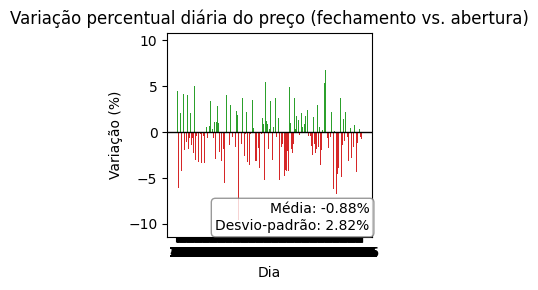

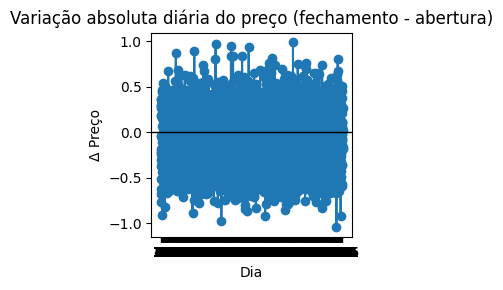

In [48]:
import random
import numpy as np
from collections import defaultdict

def discretize_state(state):
    return tuple(np.round(state, 1))

def epsilon_greedy_policy(Q, state, action_space, epsilon):
    if random.random() < epsilon:
        return action_space.sample()
    return np.argmax(Q[state])

def monte_carlo_train(env, num_train_episodes=2000, gamma=0.95, epsilon=0.1, N0=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Q(S,a) = 0
    variable_epsilon = epsilon
    returns = defaultdict(list)
    N_sa = defaultdict(int)
    N_s = defaultdict(int)
    for episode in range(num_train_episodes):
        state, _ = env.reset()
        episode_data = []
        terminated = False

        while not terminated:
            s = discretize_state(state)
            N_s[s] += 1 # update number of visits in this state
            variable_epsilon = N0 / (N0 + N_s[s]) 
            action = epsilon_greedy_policy(Q, s, env.action_space, variable_epsilon)
            next_state, reward, terminated, _, _ = env.step(action)
            episode_data.append((s, action, reward))
            state = next_state

        G = 0
        visited = set()
        for t in reversed(range(len(episode_data))):
            s, a, r = episode_data[t]
            G = gamma * G + r
            if (s, a) not in visited:
                N_sa[(s,a)] += 1
                returns[(s, a)].append(G)
                alpha = 1 / N_sa[(s,a)]
                Q[s][a] += alpha * (G - Q[s][a])
                visited.add((s, a))
    return dict(Q)
#create data to evaluate
num_train_episodes = 360*10
hours_per_day = 10
start_price = 10.22
prices = generate_intraday_prices(num_train_episodes, hours_per_day, start_price)

## 4.1 Stocrastic environment evaluation

Stochastic Monte Carlo Training...
Average reward (discounted): -4.90 ± 36.25


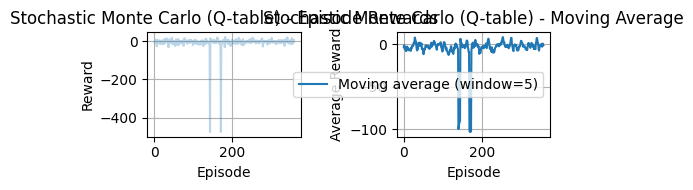

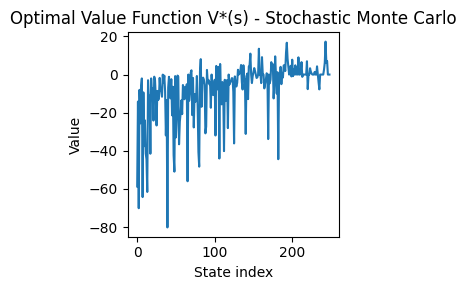

Stochastic Monte Carlo Training Done


In [49]:
# Hiperparams 
window_size = 2
num_train_episodes = 360*10 #10 years of experience
num_eval_episodes = 360*1 #1 year
gamma_mc = 0.99
gamma_ql = 0.99
gamma_sarsa = 0.8
N0 = 10
epsilon_mc = 0.75
epsilon_ql = 0.999
epsilon_sarsa = 0.999
alpha_ql = 0.1
alpha_sarsa = 0.3
hours_per_day = 10
start_price = 10.22
epsilon_decay_ql = 0.005
epsilon_min_ql = 0.2

# Linear approximator hyperparameters
linear_num_features = 8
linear_alpha = 0.01
linear_epsilon = 0.1
linear_epsilon_decay = 0.995
linear_epsilon_min = 0.01

#Helper functions to evaluate 
def evaluate(env, Q, num_episodes=100, gamma=1.0):
    """
    Evaluate a trained agent on the environment.
    Computes discounted return G_0 = sum_t gamma^t * r_t per episode
    """
    total_rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        episode_rewards_list = []

        while not terminated:
            s = discretize_state(state)
            action = np.argmax(Q[s]) if s in Q else env.action_space.sample()
            next_state, reward, terminated, _, _ = env.step(action)
            episode_rewards_list.append(reward)
            state = next_state

        # compute discounted return for this episode
        G = 0.0
        for r in reversed(episode_rewards_list):
            G = r + gamma * G
        total_rewards.append(G)

    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"Average reward (discounted): {avg_reward:.2f} ± {std_reward:.2f}")
    return total_rewards


def plot_rewards(rewards, title="Training Progress"):
    plt.figure(figsize=(5, 2))
    
    # Raw rewards
    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.3, label="Episode reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"{title} - Episode Rewards")
    plt.grid(True)
    
    # Moving average
    plt.subplot(1, 2, 2)
    window = 5
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(moving_avg, label=f"Moving average (window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.title(f"{title} - Moving Average")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plot_values(V, title="Value Function"):
    plt.figure(figsize=(3, 3))
    plt.plot(list(range(len(V))), list(V.values()))
    plt.title(f"Optimal Value Function V*(s) - {title}")
    plt.xlabel("State index")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()   

def get_value_function(Q):
    V = {}
    for s in Q:
        V[s] = np.max(Q[s])
    return V

# create data to evaluate
env = TradingEnv(data=prices, window_size=window_size)
print("Stochastic Monte Carlo Training...")
Q_mc = monte_carlo_train(env, num_train_episodes, gamma_mc, epsilon_mc, N0)
V_mc = get_value_function(Q_mc)
rewards_mc = evaluate(env, Q_mc, num_eval_episodes, gamma=gamma_mc)
plot_rewards(rewards_mc, title="Stochastic Monte Carlo (Q-table)")
plot_values(V_mc, title="Stochastic Monte Carlo")
print("Stochastic Monte Carlo Training Done")

**Discussion**
Here we can see that this result highly depends on the price variation, that in this case was -0.79%. 
It was not possible to converge to a good policy using Monte Carlo.The result demonstrated here is more stable, but it still loses some money, as the average reward remains slightly negative. 
It was executed some exeperiments by changing the window size and it was possible to see that by giving a small observation window, the results were more stable. 
The epsilon = 0.75 with decay = 0.001 make it execute the exploration with slow decay, which is needed considering the stocracity of the environment.
Choosing gamma = 0.99 favored long-term gains, which is important in trading scenarios. This result also highlights the big variance on Monte Carlo. 


## 4.2 Deterministic environment evaluation

Deterministic Monte Carlo Training...
Average reward (discounted): 26.35 ± 0.00


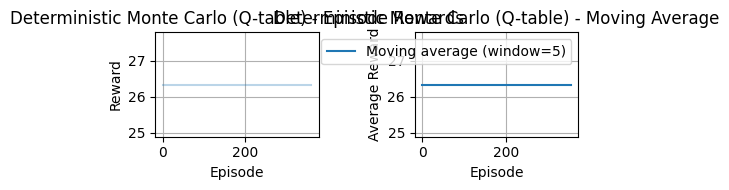

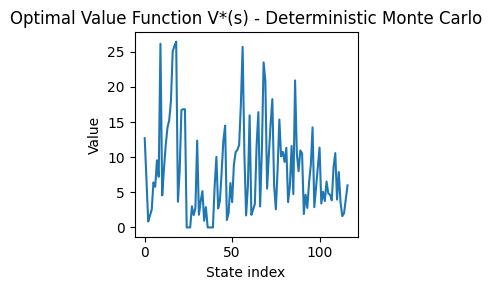

Deterministic Monte Carlo Training Done


In [50]:
det_env = DeterministicTradingEnv(n_steps=hours_per_day, start_price=start_price, window_size=window_size)
print("Deterministic Monte Carlo Training...")
det_Q_mc = monte_carlo_train(det_env, num_train_episodes, gamma_mc, epsilon_mc, N0)
det_V_mc = get_value_function(det_Q_mc)
det_rewards_mc = evaluate(det_env, det_Q_mc, num_eval_episodes, gamma=gamma_mc)
plot_rewards(det_rewards_mc, title="Deterministic Monte Carlo (Q-table)")
plot_values(det_V_mc, title="Deterministic Monte Carlo")
print("Deterministic Monte Carlo Training Done")

# 5. SARSA

In [59]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict

def discretize_state(state, decimals=1):
    """Discretizes the continuous state by rounding values."""
    return tuple(np.round(state, decimals))

def epsilon_greedy(Q, state, action_space, epsilon):
    """Epsilon-greedy policy."""
    if random.random() < epsilon:
        return action_space.sample()
    return np.argmax(Q[state])

def sarsa_train(env, num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1):
    """
    Train an agent using the SARSA (State-Action-Reward-State-Action) algorithm.
    
    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes to train
        alpha: Learning rate
        gamma: Discount factor
        epsilon: Exploration parameter (epsilon-greedy)
    
    Returns:
        Q: Trained Q-table (dictionary)
        rewards: List of accumulated rewards per episode
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        s = discretize_state(state)
        action = epsilon_greedy(Q, s, env.action_space, epsilon)
        
        episode_reward = 0
        episode_rewards_list = []
        done = False
        
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            s_next = discretize_state(next_state)
            next_action = epsilon_greedy(Q, s_next, env.action_space, epsilon)
            
            # SARSA update: Q(s,a) += alpha * (r + gamma * Q(s',a') - Q(s,a))
            Q[s][action] += alpha * (reward + gamma * Q[s_next][next_action] - Q[s][action])
            
            s = s_next
            action = next_action
            episode_reward += reward
            episode_rewards_list.append(reward)
        # compute discounted return G_0 for this episode
        G = 0.0
        for r in reversed(episode_rewards_list):
            G = r + gamma * G
        rewards.append(G)
    
    return dict(Q), rewards

## 5.1 Stochastic environment evaluation

The implementation of SARSA (State-Action-Reward-State-Action) algorithm provides on-policy learning where the agent learns the value of the action it actually takes.

Stochastic SARSA Training...
Average reward (discounted): -196.02 ± 193.91


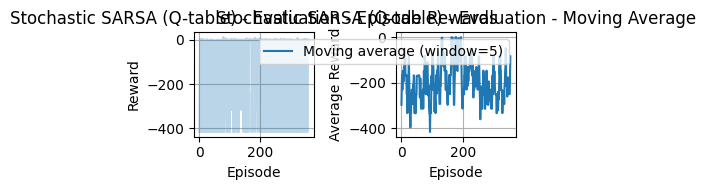

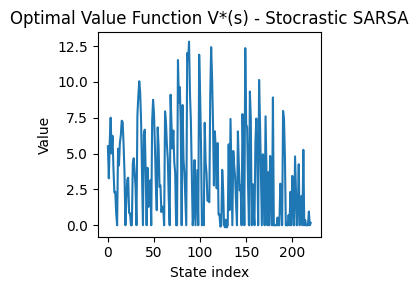

Stochastic SARSA Training Done


In [62]:
print("Stochastic SARSA Training...")
Q_sarsa, rewards_sarsa = sarsa_train(
    det_env,
    num_train_episodes,
    alpha=alpha_sarsa,
    gamma=gamma_sarsa,
    epsilon=epsilon_sarsa,
)
V_sarsa = get_value_function(Q_sarsa)
rewards_sarsa_eval = evaluate(env, det_Q_sarsa, num_eval_episodes, gamma=gamma_sarsa)
plot_rewards(rewards_sarsa_eval, title="Stochastic SARSA (Q-table) - Evaluation")
plot_values(V_sarsa, title="Stocrastic SARSA")
print("Stochastic SARSA Training Done")

## 5.2 Deterministic environment evaluation

Deterministic SARSA Training...
Average reward (discounted): 7.95 ± 0.00


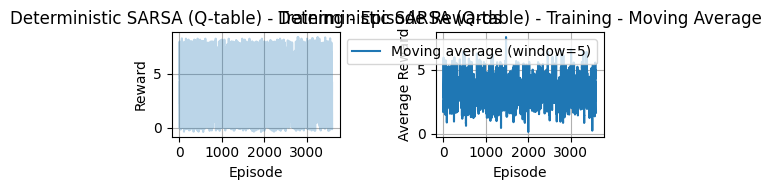

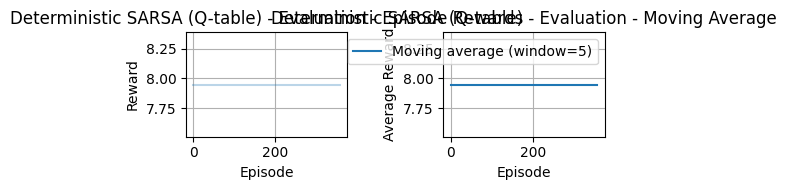

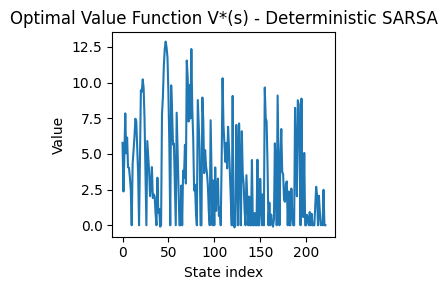

Deterministic SARSA Training Done


In [60]:
print("Deterministic SARSA Training...")
det_Q_sarsa, det_rewards_sarsa = sarsa_train(
    det_env,
    num_train_episodes,
    alpha=alpha_sarsa,
    gamma=gamma_sarsa,
    epsilon=epsilon_sarsa,
)
det_V_sarsa = get_value_function(det_Q_sarsa)
det_rewards_sarsa_eval = evaluate(det_env, det_Q_sarsa, num_eval_episodes, gamma=gamma_sarsa)
plot_rewards(det_rewards_sarsa, title="Deterministic SARSA (Q-table) - Training")
plot_rewards(det_rewards_sarsa_eval, title="Deterministic SARSA (Q-table) - Evaluation")
plot_values(det_V_sarsa, title="Deterministic SARSA")
print("Deterministic SARSA Training Done")

# 6. Q-Learning

Q-Learning is an off-policy algorithm that learns the optimal Q-values while following an exploratory policy.

In [63]:
import numpy as np
import random
from collections import defaultdict


def discretize_state(state, decimals=1):
    """Discretizes the continuous state by rounding values."""
    return tuple(np.round(state, decimals))

def epsilon_greedy(Q, state, action_space, epsilon):
    """Epsilon-greedy policy."""
    if random.random() < epsilon:
        return action_space.sample()
    return np.argmax(Q[state])

def get_value_function(Q):
    V = {}
    for s in Q:
        V[s] = np.max(Q[s])
    return V

def q_learning_train(env, num_episodes=2000, gamma=0.95, alpha=0.3, epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.1):
    """
    Train an agent using the Q-Learning algorithm.
    
    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes to train
        gamma: Discount factor
        alpha: Learning rate
        epsilon: Initial exploration parameter
        epsilon_decay: Decay rate for epsilon
        epsilon_min: Minimum epsilon value
    
    Returns:
        Q: Trained Q-table (dictionary)
        rewards: List of total rewards per episode
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        # Initialize state
        s = discretize_state(state)
        done = False
        total_reward = 0
        episode_rewards_list = []
        while not done:
            # Choose action following epsilon-greedy policy
            action = epsilon_greedy(Q, s, env.action_space, epsilon)
            # Observe reward and next state
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            episode_rewards_list.append(reward)
            s_next = discretize_state(next_state)
            # Choose best action for next state
            best_next_action = np.argmax(Q[s_next])
            if done:
                td_target = reward
            else:
                td_target = reward + gamma * Q[s_next][best_next_action]
            # Calculate temporal difference error
            td_error = td_target - Q[s][action]
            # Update Q-value
            Q[s][action] += alpha * td_error
            s = s_next
        # compute discounted return for this episode
        G = 0.0
        for r in reversed(episode_rewards_list):
            G = r + gamma * G
        rewards.append(G)
        epsilon = max(epsilon_min, epsilon - epsilon_decay*epsilon)

    return dict(Q), rewards

## 6.1 Stochastic environment evaluation

Stochastic Q-Learning Training...
Average reward (discounted): 0.00 ± 0.00


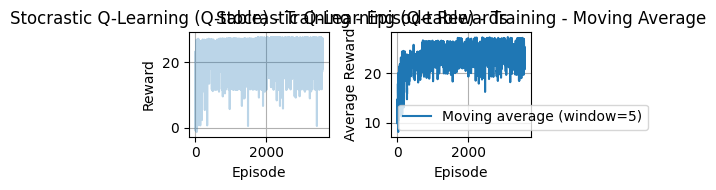

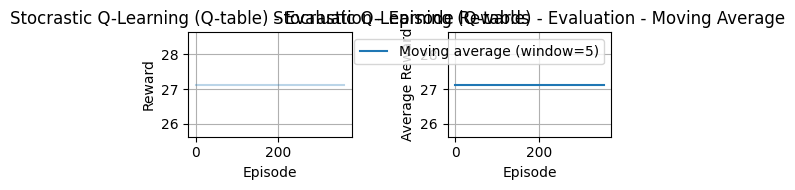

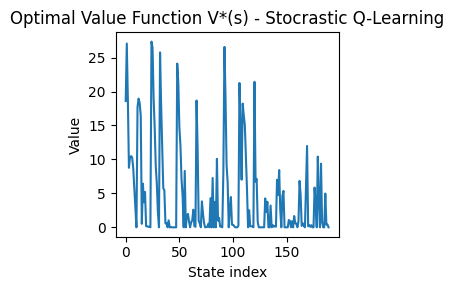

Stochastic Q-Learning Training Done


In [64]:
print("Stochastic Q-Learning Training...")
Q_ql, rewards_ql = q_learning_train(
        env,
        num_train_episodes,
        gamma=gamma_ql,
        alpha=alpha_ql,
        epsilon=epsilon_ql,
        epsilon_decay=epsilon_decay_ql,
        epsilon_min=epsilon_min_ql,
)
V_ql = get_value_function(Q_ql)
rewards_ql = evaluate(env, Q_ql, num_eval_episodes, gamma=gamma_ql)
plot_rewards(det_rewards_ql, title="Stocrastic Q-Learning (Q-table) - Training")
plot_rewards(det_rewards_ql_eval, title="Stocrastic Q-Learning (Q-table) - Evaluation")
plot_values(det_V_ql, title="Stocrastic Q-Learning")
print("Stochastic Q-Learning Training Done")


## 6.2 Deterministic environment evaluation

Deterministic Q-Learning Training...
Average reward (discounted): 27.13 ± 0.00


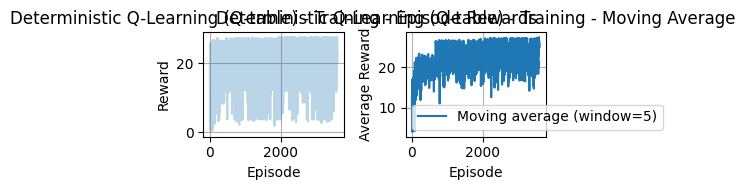

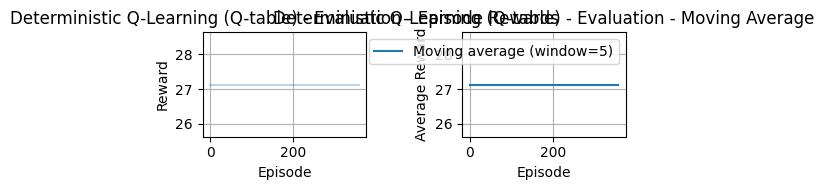

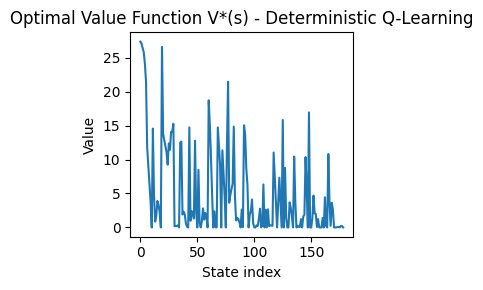

Deterministic Q-Learning Training Done


In [65]:
print("Deterministic Q-Learning Training...")
det_Q_ql, det_rewards_ql = q_learning_train(
    det_env,
    num_train_episodes,
    gamma=gamma_ql,
    alpha=alpha_ql,
    epsilon=epsilon_ql,
    epsilon_decay=epsilon_decay_ql,
    epsilon_min=epsilon_min_ql,
)
det_V_ql = get_value_function(det_Q_ql)
det_rewards_ql_eval = evaluate(det_env, det_Q_ql, num_eval_episodes, gamma=gamma_ql)
plot_rewards(det_rewards_ql, title="Deterministic Q-Learning (Q-table) - Training")
plot_rewards(det_rewards_ql_eval, title="Deterministic Q-Learning (Q-table) - Evaluation")
plot_values(det_V_ql, title="Deterministic Q-Learning")
print("Deterministic Q-Learning Training Done")

# 7. Linear Function Approximator

Linear function approximators allow RL algorithms to scale to larger or continuous state spaces by representing the value function as a linear combination of features.

In [32]:
"""
Shared linear function approximator utilities.

This module provides a single reusable `LinearFunctionApproximator`
that converts states to features and implements `predict`/`update`.
It is intended to be reused by Monte Carlo, SARSA and Q-Learning
linear approximator implementations.
"""

import numpy as np


class LinearFunctionApproximator:
    """
    Linear function approximator for value / Q-function approximation.

    Supports: predict(state) -> scalar, and update(state, target)
    where the update uses gradient descent on squared error.
    """

    def __init__(self, num_features, learning_rate=0.01, scale=100.0):
        self.num_features = num_features
        self.learning_rate = learning_rate
        self.scale = float(scale)
        self.weights = np.zeros(num_features)

    def get_features(self, state):
        if isinstance(state, tuple):
            state = np.array(state)
        elif isinstance(state, (int, float)):
            state = np.array([state])
        # Convert to float array and apply simple scaling to keep magnitudes reasonable
        state = np.asarray(state, dtype=float)
        if state.size == 0:
            state_normalized = state
        else:
            # normalize by provided scale (typically the initial price)
            state_normalized = state / self.scale

        # Linear-only features: bias + (at most) one coefficient per state dimension
        features = np.zeros(self.num_features, dtype=float)

        if self.num_features > 1 and state_normalized.size > 0:
            # number of linear features we can place
            n_lin = min(self.num_features - 1, state_normalized.size)
            features[1 : 1 + n_lin] = state_normalized[:n_lin]

        return features

    def predict(self, state):
        features = self.get_features(state)
        return float(np.dot(self.weights, features))

    def update(self, state, target_value):
        features = self.get_features(state)
        prediction = np.dot(self.weights, features)
        error = target_value - prediction
        self.weights += self.learning_rate * error * features


## 7.1 Monte Carlo with Linear Approximator - Stochastic Environment

Creating environment...

Training Monte Carlo agent with linear function approximator...

Evaluating trained agent...
Evaluation - Average reward (discounted): 0.00 ± 0.00


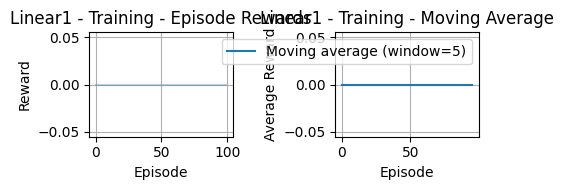


Training complete!


In [35]:
"""
Monte Carlo with Linear Function Approximator

This module demonstrates how to implement Monte Carlo reinforcement learning
using a linear function approximator instead of a Q-table.

The value function is approximated as: V(s) = w^T * phi(s)
where phi(s) is a feature vector and w are the weights to be learned.
"""
import numpy as np
import random
import matplotlib.pyplot as plt
from linear_approximator import LinearFunctionApproximator
class LinearMonteCarloAgent:
    """
    Monte Carlo agent with linear function approximator.
    """
    
    def __init__(self, action_space_n, num_features=8, alpha=0.01, gamma=0.99, epsilon=0.1, scale=100.0):
        """
        Initialize the agent.
        
        Args:
            action_space_n: Number of possible actions
            num_features: Number of features for approximator
            alpha: Learning rate
            gamma: Discount factor
            epsilon: Exploration parameter
        """
        self.action_space_n = action_space_n
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        
        # One approximator per action (pass scale to feature normalizer)
        self.approximators = [
            LinearFunctionApproximator(num_features, learning_rate=alpha, scale=scale)
            for _ in range(action_space_n)
        ]
    
    def get_action_values(self, state):
        """
        Get Q-values for all actions in a state.
        
        Args:
            state: Current state
            
        Returns:
            Array of Q-values for each action
        """
        q_values = np.array([
            approximator.predict(state)
            for approximator in self.approximators
        ])
        return q_values
    
    def select_action(self, state):
        """
        Select action using epsilon-greedy policy.
        
        Args:
            state: Current state
            
        Returns:
            Selected action
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space_n - 1)
        
        q_values = self.get_action_values(state)
        return np.argmax(q_values)
    
    def update_episode(self, episode_trajectory):
        """
        Update approximators using an episode trajectory.
        Monte Carlo uses the full return (sum of discounted rewards).
        
        Args:
            episode_trajectory: List of (state, action, reward) tuples
        """
        # Calculate returns (discounted cumulative rewards)
        returns = []
        G = 0
        
        # Work backwards through the episode
        for state, action, reward in reversed(episode_trajectory):
            G = reward + self.gamma * G
            returns.insert(0, G)
        
        # Update each state-action pair
        for (state, action, reward), G in zip(episode_trajectory, returns):
            self.approximators[action].update(state, G)


def train_with_linear_approximator(env, num_episodes=1000, num_features=8, 
                                   alpha=0.01, gamma=0.99, epsilon=0.1,
                                   epsilon_decay=0.995, epsilon_min=0.01,
                                   scale=100.0):
    """
    Train an agent using Monte Carlo with linear function approximation.
    
    Args:
        env: Gymnasium environment
        num_episodes: Number of training episodes
        num_features: Number of features for the approximator
        alpha: Learning rate
        gamma: Discount factor
        epsilon: Initial exploration parameter
        epsilon_decay: Decay rate for epsilon
        epsilon_min: Minimum epsilon value
        
    Returns:
        agent: Trained agent
        rewards: List of rewards per episode
    """
    agent = LinearMonteCarloAgent(
        env.action_space.n,
        num_features=num_features,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        scale=scale,
    )
    
    rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_trajectory = []
        episode_reward = 0
        episode_rewards_list = []
        done = False
        
        # Collect episode
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_trajectory.append((state, action, reward))
            episode_reward += reward
            episode_rewards_list.append(reward)
            state = next_state
        
        # Update agent using collected episode
        agent.update_episode(episode_trajectory)

        # Record discounted return for the episode (G_0 = sum_t gamma^t * r_t)
        G = 0.0
        for r in reversed(episode_rewards_list):
            G = r + agent.gamma * G
        rewards.append(G)
        
        # Decay epsilon
        agent.epsilon = max(epsilon_min, agent.epsilon * epsilon_decay)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])   
    return agent, rewards


def evaluate_agent(agent, env, num_episodes=100):
    """
    Evaluate a trained agent.
    
    Args:
        agent: Trained agent
        env: Gymnasium environment
        num_episodes: Number of evaluation episodes
        
    Returns:
        List of rewards per episode
    """
    rewards = []
    original_epsilon = agent.epsilon
    agent.epsilon = 0  # Greedy evaluation
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_rewards_list = []
        done = False

        while not done:
            q_values = agent.get_action_values(state)
            action = np.argmax(q_values)
            next_state, reward, done, _, _ = env.step(action)

            episode_rewards_list.append(reward)
            state = next_state

        # compute discounted return for episode
        G = 0.0
        for r in reversed(episode_rewards_list):
            G = r + agent.gamma * G
        rewards.append(G)
    
    agent.epsilon = original_epsilon
    
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(f"Evaluation - Average reward (discounted): {avg_reward:.2f} ± {std_reward:.2f}")
    
    return rewards


if __name__ == "__main__":
    import gymnasium as gym
    
    # Example: FrozenLake environment
    print("Creating environment...")
    env = gym.make("FrozenLake-v1", is_slippery=True)
    
    print("\nTraining Monte Carlo agent with linear function approximator...")
    agent, training_rewards = train_with_linear_approximator(
        env,
        num_episodes=500,
        num_features=8,
        alpha=0.01,
        gamma=0.99,
        epsilon=0.1,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )
    
    print("\nEvaluating trained agent...")
    eval_rewards = evaluate_agent(agent, env, num_episodes=100)
    
    plot_rewards(eval_rewards, title="Linear1 - Training")
    
    print("\nTraining complete!")


## 7.3 Monte Carlo with Linear Approximator - Deterministic Environment

Deterministic Monte Carlo with Linear Approximator Training...
Evaluation - Average reward (discounted): 26.35 ± 0.00


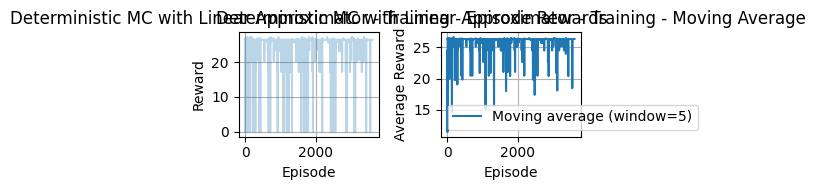

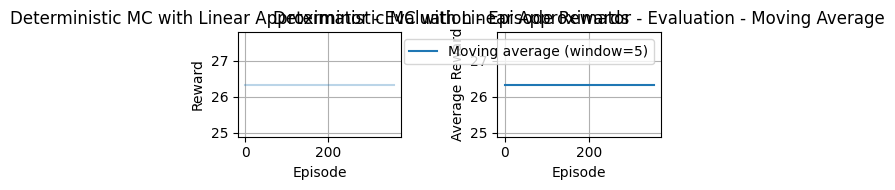

Deterministic Monte Carlo with Linear Approximator Training Done


In [66]:
print("Deterministic Monte Carlo with Linear Approximator Training...")
agent_mc_lin_det, rewards_mc_lin_det = train_with_linear_approximator(
    det_env,
    num_episodes=num_train_episodes,
    num_features=linear_num_features,
    alpha=linear_alpha,
    gamma=gamma_mc,
    epsilon=linear_epsilon,
    epsilon_decay=linear_epsilon_decay,
    epsilon_min=linear_epsilon_min,
    scale=start_price,
)
rewards_mc_lin_det_eval = evaluate_mc_agent(agent_mc_lin_det, det_env, num_eval_episodes)
plot_rewards(rewards_mc_lin_det, title="Deterministic MC with Linear Approximator - Training")
plot_rewards(rewards_mc_lin_det_eval, title="Deterministic MC with Linear Approximator - Evaluation")
print("Deterministic Monte Carlo with Linear Approximator Training Done")

## 7.4 SARSA with Linear Approximator - Stochastic Environment

Stochastic SARSA with Linear Approximator Training...
Evaluation - Average reward: -2.44 ± 11.33


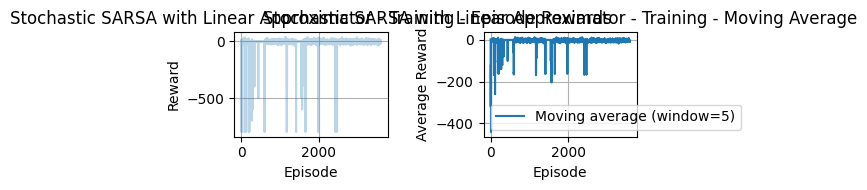

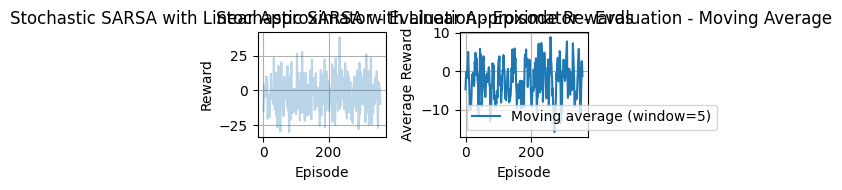

Stochastic SARSA with Linear Approximator Training Done


In [67]:
print("Stochastic SARSA with Linear Approximator Training...")
agent_sarsa_lin, rewards_sarsa_lin = train_sarsa_linear(
    env,
    num_episodes=num_train_episodes,
    num_features=linear_num_features,
    alpha=linear_alpha,
    gamma=gamma_sarsa,
    epsilon=linear_epsilon,
    epsilon_decay=linear_epsilon_decay,
    epsilon_min=linear_epsilon_min,
    scale=start_price,
)
rewards_sarsa_lin_eval = evaluate_sarsa_agent(agent_sarsa_lin, env, num_eval_episodes)
plot_rewards(rewards_sarsa_lin, title="Stochastic SARSA with Linear Approximator - Training")
plot_rewards(rewards_sarsa_lin_eval, title="Stochastic SARSA with Linear Approximator - Evaluation")
print("Stochastic SARSA with Linear Approximator Training Done")

## 7.5 SARSA with Linear Approximator - Deterministic Environment

Deterministic SARSA with Linear Approximator Training...
Evaluation - Average reward: 28.05 ± 0.00


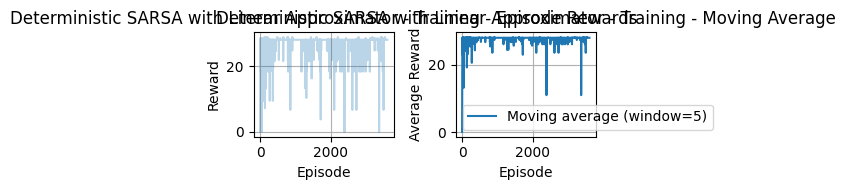

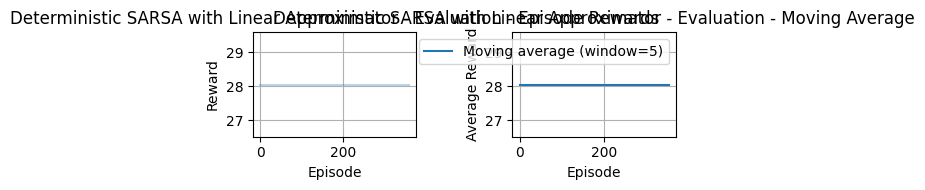

Deterministic SARSA with Linear Approximator Training Done


In [68]:
print("Deterministic SARSA with Linear Approximator Training...")
agent_sarsa_lin_det, rewards_sarsa_lin_det = train_sarsa_linear(
    det_env,
    num_episodes=num_train_episodes,
    num_features=linear_num_features,
    alpha=linear_alpha,
    gamma=gamma_sarsa,
    epsilon=linear_epsilon,
    epsilon_decay=linear_epsilon_decay,
    epsilon_min=linear_epsilon_min,
    scale=start_price,
)
rewards_sarsa_lin_det_eval = evaluate_sarsa_agent(agent_sarsa_lin_det, det_env, num_eval_episodes)
plot_rewards(rewards_sarsa_lin_det, title="Deterministic SARSA with Linear Approximator - Training")
plot_rewards(rewards_sarsa_lin_det_eval, title="Deterministic SARSA with Linear Approximator - Evaluation")
print("Deterministic SARSA with Linear Approximator Training Done")

## 7.6 Q-Learning with Linear Approximator - Stochastic Environment

Stochastic Q-Learning with Linear Approximator Training...
Evaluation - Average reward: -2.94 ± 11.03


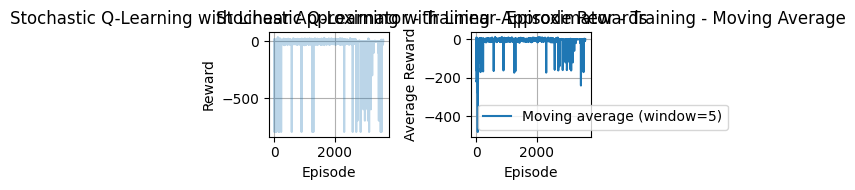

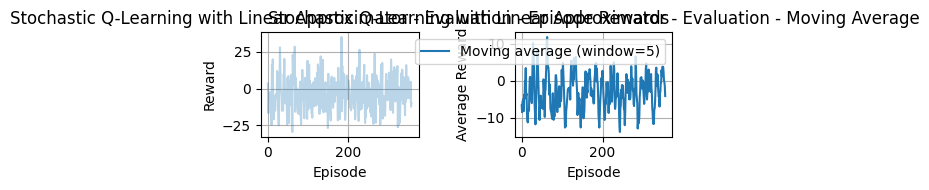

Stochastic Q-Learning with Linear Approximator Training Done


In [69]:
print("Stochastic Q-Learning with Linear Approximator Training...")
agent_ql_lin, rewards_ql_lin = train_q_learning_linear(
    env,
    num_episodes=num_train_episodes,
    num_features=linear_num_features,
    alpha=linear_alpha,
    gamma=gamma_ql,
    epsilon=linear_epsilon,
    epsilon_decay=linear_epsilon_decay,
    epsilon_min=linear_epsilon_min,
    scale=start_price,
)
rewards_ql_lin_eval = evaluate_q_learning_agent(agent_ql_lin, env, num_eval_episodes)
plot_rewards(rewards_ql_lin, title="Stochastic Q-Learning with Linear Approximator - Training")
plot_rewards(rewards_ql_lin_eval, title="Stochastic Q-Learning with Linear Approximator - Evaluation")
print("Stochastic Q-Learning with Linear Approximator Training Done")

## 7.7 Q-Learning with Linear Approximator - Deterministic Environment

Deterministic Q-Learning with Linear Approximator Training...
Evaluation - Average reward: 28.05 ± 0.00


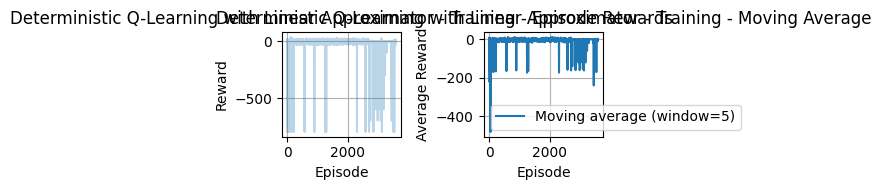

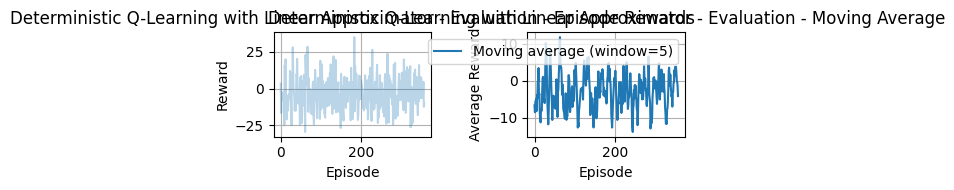

Deterministic Q-Learning with Linear Approximator Training Done


In [72]:
print("Deterministic Q-Learning with Linear Approximator Training...")
agent_ql_lin_det, rewards_ql_lin_det = train_q_learning_linear(
        det_env,
        num_episodes=num_train_episodes,
        num_features=linear_num_features,
        alpha=linear_alpha,
        gamma=gamma_ql,
        epsilon=linear_epsilon,
        epsilon_decay=linear_epsilon_decay,
        epsilon_min=linear_epsilon_min,
        scale=start_price,
)
rewards_ql_lin_det_eval = evaluate_q_learning_agent(agent_ql_lin_det, det_env, num_eval_episodes)
plot_rewards(rewards_ql_lin, title="Deterministic Q-Learning with Linear Approximator - Training")
plot_rewards(rewards_ql_lin_eval, title="Deterministic Q-Learning with Linear Approximator - Evaluation")
print("Deterministic Q-Learning with Linear Approximator Training Done")

# 8. Discussion

# 9. Conclusion